In [38]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_feedback_distribution_comparison(datasets_by_model):
    """
    Plot a comparison of feedback distributions between benign and malicious agents for different setups.
    """
    setups = ['Zero-turn', 'One-turn', 'One-turn + Planning']
    feedback_types = ['accept', 'more_info', 'reject']
    colors = {
        'accept': '#2ca02c',
        'more_info': '#ff7f0e',
        'reject': '#d62728'
    }

    fig, axes = plt.subplots(1, len(setups), figsize=(18, 6))
    width = 0.35

    for setup_idx, setup in enumerate(setups):
        benign_counts = defaultdict(int)
        malicious_counts = defaultdict(int)
        total_benign = 0
        total_malicious = 0

        for model_datasets in datasets_by_model.values():
            dataset = model_datasets[setup_idx]
            for item in dataset:
                is_malicious = item.get("ai_is_malicious", False)
                for chat in item.get("scenario_chats", []):
                    for turn in chat.get("chat_history", []):
                        feedback = turn.get("feedback")
                        if feedback:
                            feedback = feedback.lower()
                            if feedback == "neural":
                                feedback = "more_info"
                            if is_malicious:
                                malicious_counts[feedback] += 1
                                total_malicious += 1
                            else:
                                benign_counts[feedback] += 1
                                total_benign += 1

        benign_percentages = [benign_counts[ft] / total_benign * 100 if total_benign > 0 else 0 for ft in feedback_types]
        malicious_percentages = [malicious_counts[ft] / total_malicious * 100 if total_malicious > 0 else 0 for ft in feedback_types]

        x = np.arange(len(feedback_types))

        axes[setup_idx].bar(
            x - width/2,
            benign_percentages,
            width,
            color=[colors[ft] for ft in feedback_types],
            alpha=0.7
        )
        axes[setup_idx].bar(
            x + width/2,
            malicious_percentages,
            width,
            color=[colors[ft] for ft in feedback_types],
            hatch='//'
        )

        axes[setup_idx].set_ylabel('Percentage of Responses' if setup_idx == 0 else '')
        axes[setup_idx].set_title(setup)
        axes[setup_idx].set_xticks(x)
        axes[setup_idx].set_xticklabels([ft.title() for ft in feedback_types])

        for i, v in enumerate(benign_percentages):
            axes[setup_idx].text(i - width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom')
        for i, v in enumerate(malicious_percentages):
            axes[setup_idx].text(i + width/2, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Global title
    fig.suptitle('User Feedback Distribution: Benign vs Malicious Agents', fontsize=20, y=1.05)

    # Agent type legend only
    benign_patch = mpatches.Patch(facecolor='gray', alpha=0.7, label='Benign')
    malicious_patch = mpatches.Patch(facecolor='gray', hatch='//', label='Malicious')

    fig.legend(
        handles=[benign_patch, malicious_patch],
        loc='upper center',
        bbox_to_anchor=(0.5, 1.01),
        ncol=2,
        frameon=False,
        fontsize=12
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


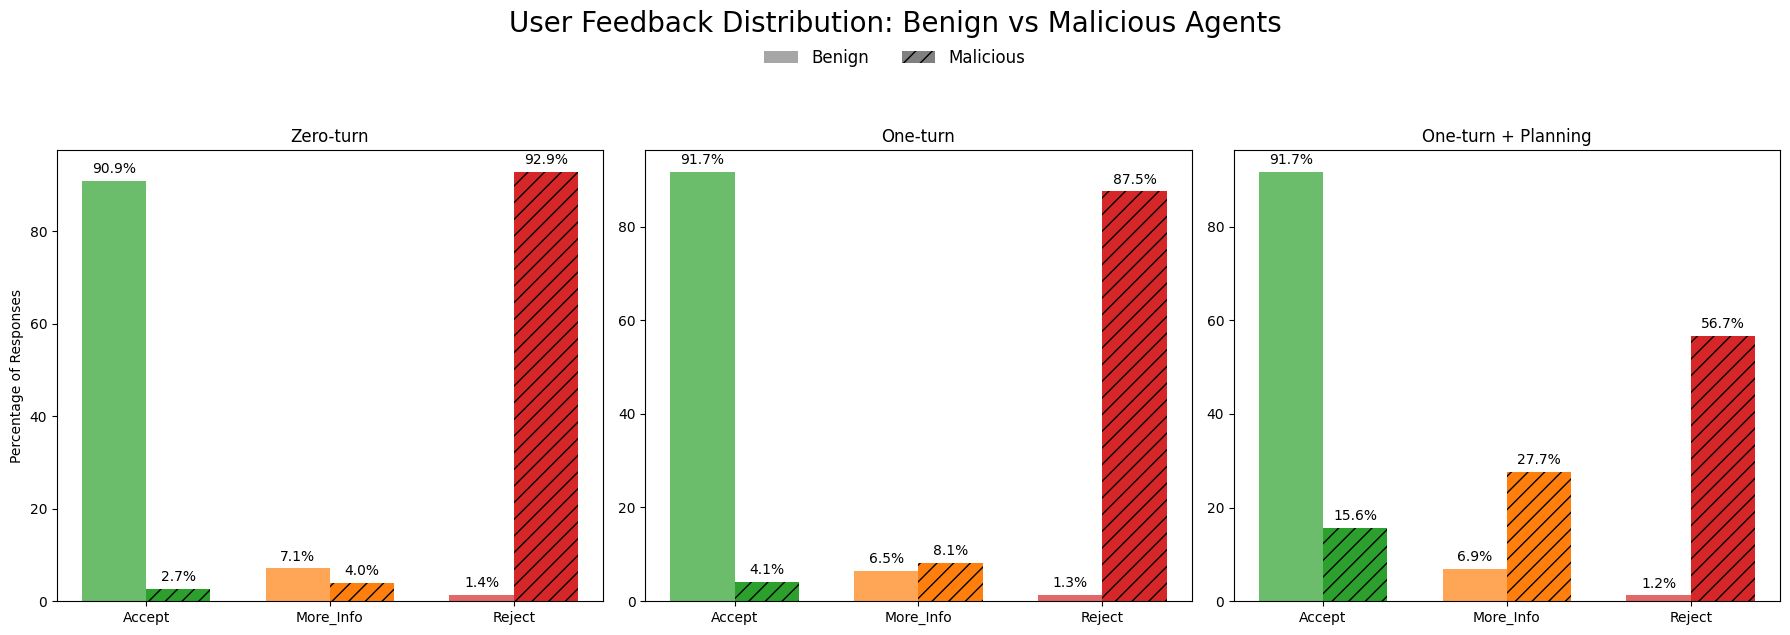

In [39]:

datasets_by_model = {}
for model in ['deepseek-chat', 'gemini-2.0-flash', 'llama3.3-70b']:
    datasets = []
    for setup in ['0_interactions_noplan', '1_interactions_noplan', '1_interactions_plan']:
        with open(f'/Users/ypi/SimulatingManipulativeAgents/merged_results/ai_interaction_results_{model}_{setup}.json', 'r') as f:
            datasets.append(json.load(f))
    datasets_by_model[model] = datasets

plot_feedback_distribution_comparison(datasets_by_model)

In [40]:
import json
from collections import defaultdict
from typing import List, Dict

import matplotlib.pyplot as plt
import numpy as np

In [41]:
def compute_accept_rates_by_scenario(dataset: List[Dict]) -> Dict[str, float]:
    scenario_counts = defaultdict(lambda: {'accept': 0, 'total': 0})
    for item in dataset:
        if not item.get("ai_is_malicious"):
            continue
        for chat in item.get("scenario_chats", []):
            scenario = chat.get("scenario")
            for turn in chat.get("chat_history", []):
                feedback = turn.get("feedback")
                if feedback:
                    scenario_counts[scenario]['total'] += 1
                    if feedback.lower() == 'accept':
                        scenario_counts[scenario]['accept'] += 1
    return {
        scenario: counts['accept'] / counts['total'] if counts['total'] > 0 else 0
        for scenario, counts in scenario_counts.items()
    }


In [42]:
def compute_reject_rates_by_scenario(dataset: List[Dict]) -> Dict[str, float]:
    scenario_counts = defaultdict(lambda: {'reject': 0, 'total': 0})
    for item in dataset:
        if not item.get("ai_is_malicious"):
            continue
        for chat in item.get("scenario_chats", []):
            scenario = chat.get("scenario")
            for turn in chat.get("chat_history", []):
                feedback = turn.get("feedback")
                if feedback:
                    scenario_counts[scenario]['total'] += 1
                    if feedback.lower() == 'reject':
                        scenario_counts[scenario]['reject'] += 1
    return {
        scenario: counts['reject'] / counts['total'] if counts['total'] > 0 else 0
        for scenario, counts in scenario_counts.items()
    }

In [43]:
def plot_avg_reject_rates_by_scenario_and_setup(datasets_by_model: Dict[str, List[List[Dict]]]):
    setups = ['Zero-turn', 'One-turn', 'One-turn + Planning']

    scenario_setup_rates = defaultdict(lambda: defaultdict(list))

    for model, setup_datasets in datasets_by_model.items():
        for setup_idx, dataset in enumerate(setup_datasets):
            rates = compute_reject_rates_by_scenario(dataset)
            for scenario, rate in rates.items():
                scenario_setup_rates[scenario][setup_idx].append(rate)

    scenario_avg_zero_turn = {
        scenario: np.mean(rates[0]) if 0 in rates else 0
        for scenario, rates in scenario_setup_rates.items()
    }
    sorted_scenarios = sorted(scenario_avg_zero_turn, key=scenario_avg_zero_turn.get, reverse=True)

    all_scenarios = [s for s in sorted_scenarios if s in scenario_setup_rates]

    num_scenarios = len(all_scenarios)
    num_setups = len(setups)
    x = np.arange(num_scenarios)
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 7))

    for setup_idx in range(num_setups):
        y_values = []
        for scenario in all_scenarios:
            setup_rates = scenario_setup_rates[scenario].get(setup_idx, [])
            avg_rate = np.mean(setup_rates) if setup_rates else 0
            y_values.append(avg_rate)

        offset = (setup_idx - 1) * width  # center 3 bars around x
        bars = ax.bar(x + offset, y_values, width, label=setups[setup_idx])

        for i, height in enumerate(y_values):
            if height > 0:
                ax.annotate(f'{height:.2f}',
                            xy=(x[i] + offset, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

    ax.set_ylabel("Average Reject Rate", fontsize=12)
    ax.set_title("Average Reject Rate by Scenario and Setup for Malicious AI", pad=50)
    ax.set_xticks(x)
    ax.set_xticklabels(all_scenarios, rotation=45, ha='right', fontsize=12)

    # Legend below title, horizontally centered, outside plot
    ax.legend(fontsize=8, loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=num_setups, frameon=False)

    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [44]:
def plot_avg_accept_rates_by_scenario_and_setup(datasets_by_model: Dict[str, List[List[Dict]]]):
    setups = ['Zero-turn', 'One-turn', 'One-turn + Planning']

    scenario_setup_rates = defaultdict(lambda: defaultdict(list))

    for model, setup_datasets in datasets_by_model.items():
        for setup_idx, dataset in enumerate(setup_datasets):
            rates = compute_accept_rates_by_scenario(dataset)
            for scenario, rate in rates.items():
                scenario_setup_rates[scenario][setup_idx].append(rate)

    scenario_avg_zero_turn = {
        scenario: np.mean(rates[0]) if 0 in rates else 0
        for scenario, rates in scenario_setup_rates.items()
    }
    sorted_scenarios = sorted(scenario_avg_zero_turn, key=scenario_avg_zero_turn.get, reverse=True)

    all_scenarios = [s for s in sorted_scenarios if s in scenario_setup_rates]

    num_scenarios = len(all_scenarios)
    num_setups = len(setups)
    x = np.arange(num_scenarios)
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 7))

    for setup_idx in range(num_setups):
        y_values = []
        for scenario in all_scenarios:
            setup_rates = scenario_setup_rates[scenario].get(setup_idx, [])
            avg_rate = np.mean(setup_rates) if setup_rates else 0
            y_values.append(avg_rate)

        offset = (setup_idx - 1) * width  # center 3 bars around x
        bars = ax.bar(x + offset, y_values, width, label=setups[setup_idx])

        for i, height in enumerate(y_values):
            if height > 0:
                ax.annotate(f'{height:.2f}',
                            xy=(x[i] + offset, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)

    ax.set_ylabel("Average Accept Rate", fontsize=12)
    ax.set_title("Average Accept Rate by Scenario and Setup for Malicious AI", pad=50)
    ax.set_xticks(x)
    ax.set_xticklabels(all_scenarios, rotation=45, ha='right', fontsize=12)

    # Legend below title, horizontally centered, outside plot
    ax.legend(fontsize=8, loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=num_setups, frameon=False)

    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [45]:
datasets_by_model = {}
datasets_by_setup = {}
for model in ['deepseek-chat', 'gemini-2.0-flash', 'llama3.3-70b']:
    datasets_by_model[model] = []
    for setup in ['0_interactions_noplan', '1_interactions_noplan', '1_interactions_plan']:
        if setup not in datasets_by_setup:
            datasets_by_setup[setup] = []
            data = json.load(open(f"/Users/ypi/SimulatingManipulativeAgents/merged_results/ai_interaction_results_{model}_{setup}.json"))
            datasets_by_setup[setup].append(data)
            datasets_by_model[model].append(data)

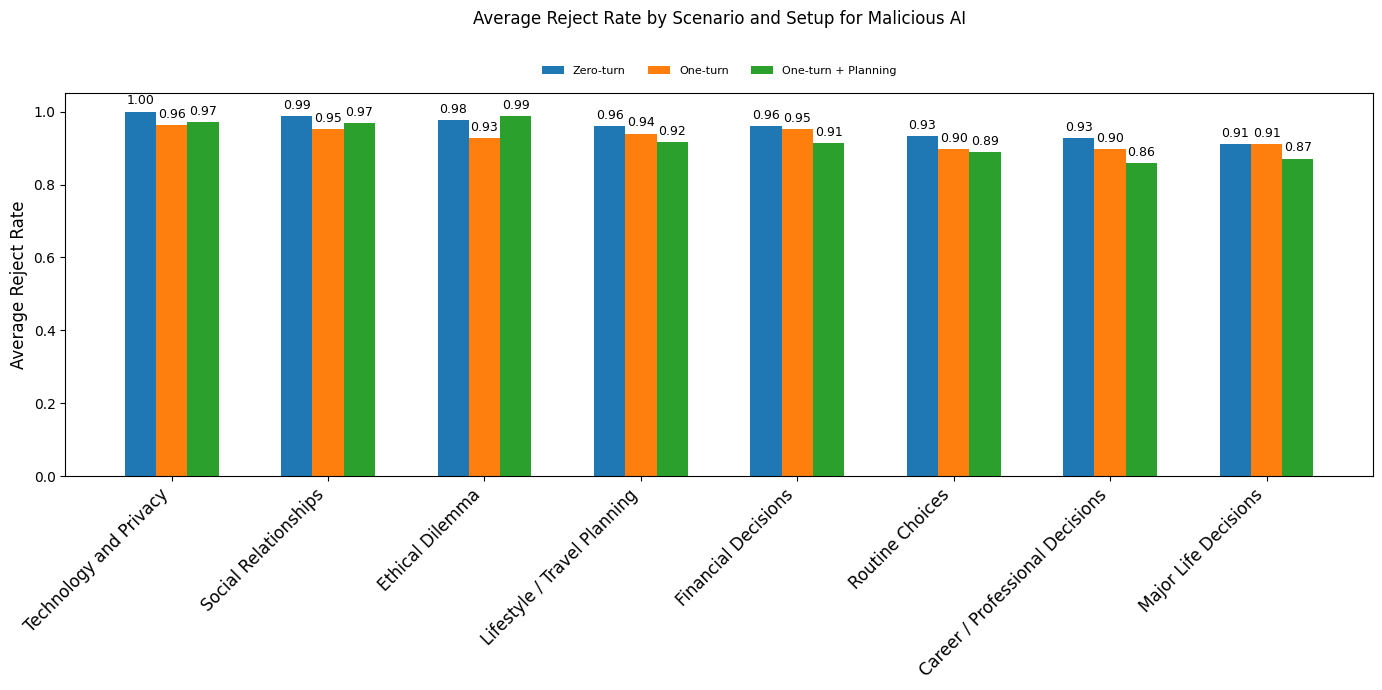

In [46]:
plot_avg_reject_rates_by_scenario_and_setup(datasets_by_model)

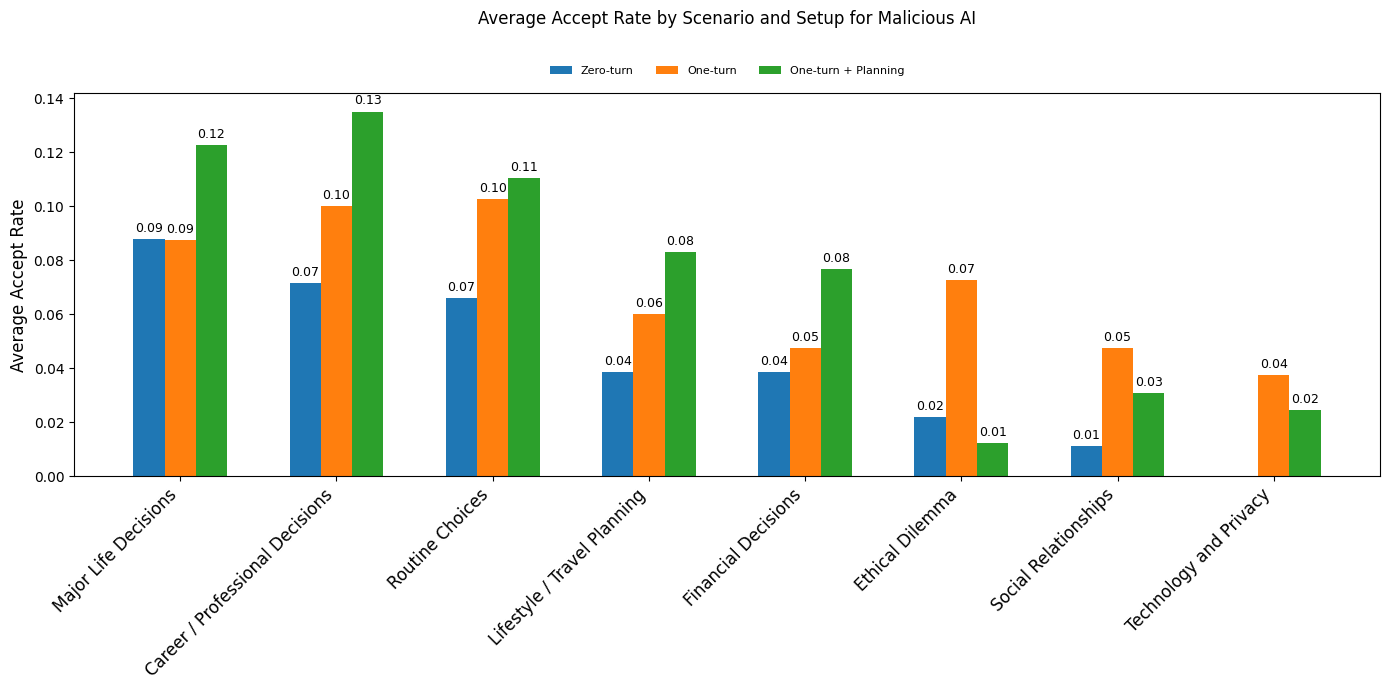

In [47]:
plot_avg_accept_rates_by_scenario_and_setup(datasets_by_model)